In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
print(train.shape)
print(test.shape)

(891, 12)
(418, 11)


In [6]:
train.drop(['Name','Ticket','Cabin'],axis=1,inplace=True)
test.drop(['Name','Ticket','Cabin'],axis=1,inplace=True)
# factors on which the survival does not depend

In [7]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64

<Axes: >

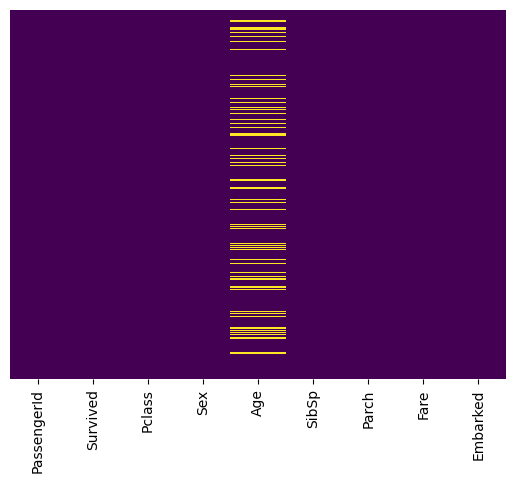

In [11]:
#Plotting null values heatmap
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

/tmp/ipykernel_20/1377056137.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = train.corr()


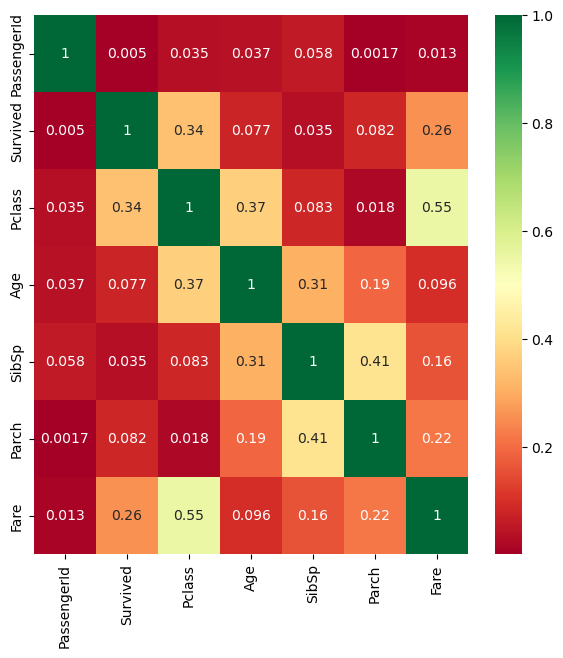

In [12]:
#Plotting correlation heatmap
corr = train.corr()
corr = corr.apply(abs)
plt.figure(figsize=(7,7))
map = sns.heatmap(corr,annot=True,cmap="RdYlGn")

0    549
1    342
Name: Survived, dtype: int64

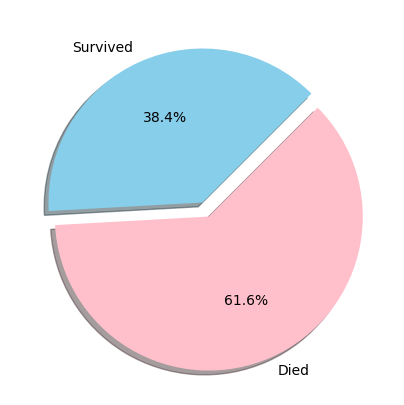

In [13]:
#Plotting the Pie chart
fig = plt.figure(figsize=(5,5))
colors = ["skyblue",'pink']
surv = train[train['Survived']==1]
died = train[train['Survived']==0]
ck = [surv['Survived'].count(),died['Survived'].count()]
piechart = plt.pie(ck,labels=["Survived","Died"],
autopct ='%1.1f%%',
shadow = True,
colors = colors,
startangle = 45,
explode=(0, 0.1))
train.Survived.value_counts()

<Axes: xlabel='Age', ylabel='Count'>

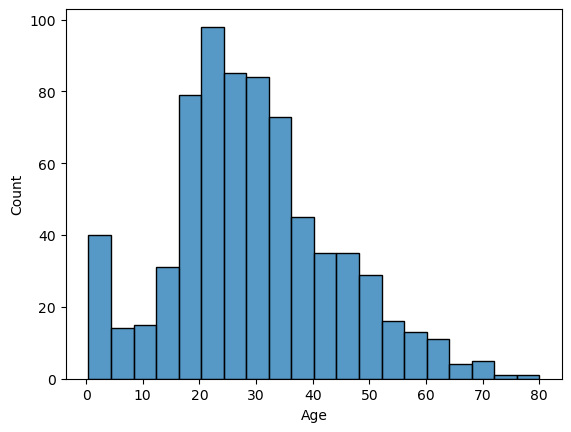

In [14]:
sns.histplot(train['Age'].dropna())

<Axes: xlabel='Parch', ylabel='Count'>

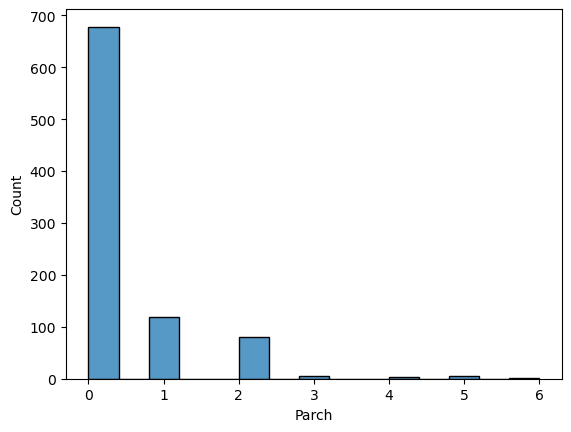

In [15]:
sns.histplot(train['Parch'].dropna(),bins=15)

<Axes: xlabel='Pclass', ylabel='Count'>

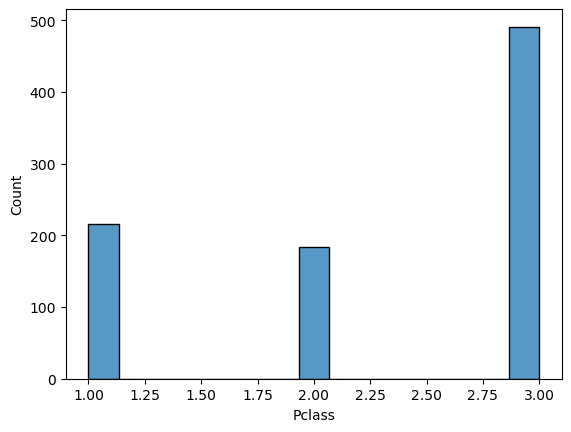

In [16]:
sns.histplot(train['Pclass'].dropna(),bins=15)

In [17]:
#Mappping categorical to numeric
train['Sex']=train['Sex'].map({'male':0,'female':1})
test['Sex']=test['Sex'].map({'male':0,'female':1})

In [18]:
train['Age'].fillna(train['Age'].mean(),inplace=True)
test['Age'].fillna(test['Age'].mean(),inplace=True)

In [19]:
#Replacing 0’s & nulls by column mean
train['Fare'] = train['Fare'].replace(0, train['Fare'].mean())
train['Fare'].replace('nan',np.nan,inplace=True)
train['Fare'].fillna(train['Fare'].mean(),inplace=True)
test['Fare'] = test['Fare'].replace(0, test['Fare'].mean())
test['Fare'].replace('nan',np.nan,inplace=True)
test['Fare'].fillna(test['Fare'].mean(),inplace=True)

In [20]:
#Replacing nulls by column mean 
train['Embarked'].replace('nan',np.nan,inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0],inplace=True)
test['Embarked'].replace('nan',np.nan,inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0],inplace=True)

In [21]:
#Printing unique values in 'Sex' column
train['Sex'].unique()

array([0, 1])

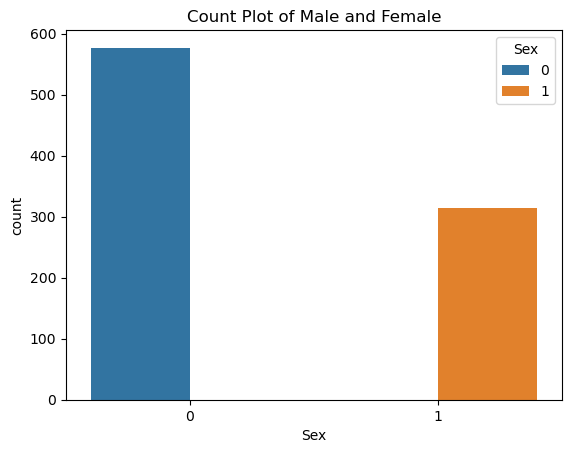

In [22]:
sns.countplot(data=train, x='Sex', hue='Sex')
plt.title('Count Plot of Male and Female')
plt.show()

In [23]:
#Mappping categorical to numeric
train['Embarked']=train['Embarked'].map({'S':0,'C':1,'Q':2})
test['Embarked']=test['Embarked'].map({'S':0,'C':1,'Q':2})

In [24]:
#Handling skewness in 'Age' column
train['Age']=np.log(train['Age'])
test['Age']=np.log(test['Age'])

In [25]:
#Handling skewness in 'Fare' column
test['Fare']=np.log(test['Fare'])
train['Fare']=np.log(train['Fare'])

In [26]:
x_train=train.drop(['Survived'],axis=1)
y_train=train['Survived']

In [27]:
#Defining the parameters to search within
param_grid = {
'n_estimators': range(6, 10),
'max_depth': range(3, 8),
'learning_rate': [.2, .3, .4],
'colsample_bytree': [.7, .8, .9, 1]
}
#Specifying our classifier
xgb = XGBClassifier()
#Searching for the best parameters
g_search = GridSearchCV(estimator = xgb, param_grid = param_grid,
cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)
#Fitting the model using best parameters found
g_search.fit(x_train, y_train)
#Printing the best parameters found
print(g_search.best_params_)

{'colsample_bytree': 0.7, 'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 7}


In [28]:
y_pred = g_search.predict(test)

In [29]:
submission_df = pd.DataFrame({
    'PassengerId': test['PassengerId'],  # Replace with your test dataset's unique identifier
    'Survived': y_pred  # Replace with your predicted target variable
})
submission_df.to_csv('submission.csv', index=False)